<a href="https://colab.research.google.com/github/mcooper98/LoU/blob/master/Copy_of_spacetitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic: Predict which passengers are transported to an alternate dimension

![SpaceshipTitanic.png](https://as2.ftcdn.net/v2/jpg/02/56/55/55/1000_F_256555513_QsIlNM1niJvoOsycvYmLo5jz5ronf8Kw.jpg)!

## Abstract
In this Kaggle competition, our task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. 
To help us make these predictions, we're given a set of personal records recovered from the ship's damaged computer system, in train.csv dataset and test.csv dataset. 


## Dataset
The data is collected from [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/): *Spaceship Titanic*

The two datasets used in this project are:
- train.csv:  Personal records for about two-thirds (8693) of the passengers, to be used as training data. It consists of 14 columns: PassengerID, HomePlanet,CryoSleep, Cabin, Destination, Age, VIP, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Name, and Transported
- test.csv: Personal records for the remaining one-third (4277) of the passengers, to be used as test data. Our task is to predict the value of Transported for the passengers in this set. It consists of 13 columns (excluding Transported column)

After processing the data, we are left with 8693 records & 16 attributes for Train DataFrame, and 4277 records & 15 attributes for Test DataFrame.


### Reading and loading the dataset into Dataframe objects
The first step is to read the .csv file using Pandas, then load it as train_df and test_df Dataframes

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import csv
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving test(1).csv to test(1) (4).csv
Saving train(1).csv to train(1) (4).csv
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load the datasets to train_df and test_df
train_df = pd.read_csv("train(1).csv")
test_df = pd.read_csv("test(1).csv")

# Set the option to always show all columns
pd.set_option('display.max_columns', None)

# Print the total row and column of each dataset
print('Train set shape:', train_df.shape)
print('Test set shape:', test_df.shape)

Train set shape: (8693, 14)
Test set shape: (4277, 13)


In [ ]:
# Preview the first five rows of test DataFrame
test_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupPassId,Deck,Num,Side
0,Earth,True,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0,13,1,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0,18,1,F,4,S
2,Europa,True,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0,19,1,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,0,0.0,6652.0,0.0,181.0,585.0,21,1,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,0,10.0,0.0,635.0,0.0,0.0,23,1,F,5,S


#### *Column Descriptions*
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [ ]:
print("Survivor in Train_DF: " + str(train_df['Transported'].sum()) + " / " + str(train_df['Transported'].count()) + " (" + str(train_df['Transported'].sum()/8693*100) + "%)")

Survivor in Train_DF: 4378 / 8693 (50.362360519958585%)


### Cleaning the Dataframe
Checking if there are any null values or duplicate entries, and the data types of each column.

#### Checking Null Values

In [ ]:
print('Train DataFrame Null Values:')
print(train_df.isna().sum())
print('\nTest DataFrame Null Values:')
print(test_df.isna().sum())

Train DataFrame Null Values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Test DataFrame Null Values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


After the data processing, we will create multiple dataframes each with different treatment to the null values.

#### Checking for duplicate entries

In [ ]:
print('Duplicate(s) in Train DataFrame:', str(train_df.duplicated().any()))
print('Duplicate(s) in Test DataFrame:', str(test_df.duplicated().any()))

Duplicate(s) in Train DataFrame: False
Duplicate(s) in Test DataFrame: False


Since there are no duplicate entries in each datasets, we can now proceed to check the data types for each columns.

#### Checking the Data Types and its Unique Values

In [ ]:
# Checking the total non-null rows from each columns and its data type
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
train_df_columns = train_df.columns

print('Total unique values in each columns:\n------------------------------------')

for el in train_df_columns:
    print("{0}: {1}".format(el, len(train_df[el].unique())))

Total unique values in each columns:
------------------------------------
PassengerId: 8693
HomePlanet: 4
CryoSleep: 3
Cabin: 6561
Destination: 4
Age: 81
VIP: 3
RoomService: 1274
FoodCourt: 1508
ShoppingMall: 1116
Spa: 1328
VRDeck: 1307
Name: 8474
Transported: 2


### Data Processing
#### Splitting the values in 'PassengerId' column to 'GroupId' & 'GroupPassId'
> **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

As mentioned in the description above, the 'PassengerId' column consist of the passenger's group and their number within the group. For that reason, we need to split the values into 2 columns, 'GroupId', and 'GroupPassId'.

*Example:* 0001_01 -> 0001 for 'GroupId', & 01 for 'GroupPassId'

In [ ]:
# Split the values in 'Cabin' column into new columns: 'Deck', 'Num', and 'Side'
train_df[['GroupId', 'GroupPassId']] =  train_df['PassengerId'].str.split('_', expand = True)
test_df[['GroupId', 'GroupPassId']] =  test_df['PassengerId'].str.split('_', expand = True)

# Drop 'Cabin' column
train_df.drop(['PassengerId'], axis =1, inplace = True)
test_df.drop(['PassengerId'], axis =1, inplace = True)

# Preview the first three rows of train DataFrame
train_df.head(3)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,GroupPassId
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01


#### Splitting the values in 'Cabin' column to 'Deck', 'Num', and 'Side' columns
> Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

For the same reason as before, since the 'Cabin' column consist of three other variables (the deck, number & side), we are going to split the values into 3 parts.

*Example:* B/0/P -> B for 'Deck', 0 for 'Num', & P for 'Side'

In [ ]:
# Split the values in 'Cabin' column into new columns: 'Deck', 'Num', and 'Side'
train_df[['Deck','Num', 'Side']] = train_df['Cabin'].str.split('/', expand = True)
test_df[['Deck','Num', 'Side']] = test_df['Cabin'].str.split('/', expand = True)

# Drop 'Cabin' column
train_df.drop(['Cabin'], axis =1, inplace = True)
test_df.drop(['Cabin'], axis =1, inplace = True)

# Preview the first three rows of train DataFrame
train_df.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,GroupPassId,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S


#### Dropping 'Name' column
The next step is to drop 'Name' column since it cannot be used as a determinant factor.

In [ ]:
train_df = train_df.drop(['Name'], axis = 1)
test_df = test_df.drop(['Name'], axis = 1)

# Preview the first three rows of train DataFrame
train_df.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupPassId,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S


#### Changing Boolean values into a Binary (0 or 1) value 
For every columns that has a boolean datatype, we will replace the False input to '0', and the True input to '1'

In [ ]:
# Replace null values in VIP to "False"
train_df['VIP'].fillna(False, inplace = True)
test_df['VIP'].fillna(False, inplace = True)

# Select all columns with boolean as its data type
bool_columns = train_df.select_dtypes("boolean").columns

# Replacing all columns with Boolean datatype with a Binary data
for el in bool_columns:
    try:
        test_df[el].replace({False: 0, True: 1}, inplace = True)
    except Exception:
        pass
    train_df[el].replace({False: 0, True: 1}, inplace = True)

train_df.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupPassId,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0001,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0002,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0003,01,A,0,S


In [ ]:
# Checking the total non-null rows from each columns and its data type
train_df.dtypes

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported       int64
GroupId          object
GroupPassId      object
Deck             object
Num              object
Side             object
dtype: object

#### Convert 'GroupId', 'GroupPassId', and 'Num' columns data types from Object to int64

In [ ]:
obj_to_int_cols = ['GroupId', 'GroupPassId', 'Num']

# Change the data type for both train and test dataset
for el in obj_to_int_cols:
    train_df[el] =  train_df[el].str.extract('(\d+)', expand=False).astype('float').astype('Int64')
    test_df[el] =  test_df[el].str.extract('(\d+)', expand=False).astype('float').astype('Int64')

In [ ]:
train_df.dtypes

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported       int64
GroupId           Int64
GroupPassId       Int64
Deck             object
Num               Int64
Side             object
dtype: object

### Different Variants of Dataframes
1. Drop all null values,
2. Replacing the null values with 0 for $ amount, mean for age, and "NoDataFound" for categorical columns
3. One Hot Encoding on each dataframes

#### Variant #1: train_df_nulldropped, test_df_nulldropped

In [ ]:
# 'all_dataframes' list consists of the name of all dataframes we have in this project
all_dataframes = list()

# Create train and test dataframes with the null values dropped
train_df_nulldropped = train_df.dropna()
test_df_nulldropped = test_df.dropna()

# Append the name of the dataframe objects to keep track of all the dataframes we have
all_dataframes.append("train_df")
all_dataframes.append("test_df")
all_dataframes.append("train_df_nulldropped")
all_dataframes.append("test_df_nulldropped")

# Display the number of rows and columns of both dataframes after the null values are dropped
print("Train_df shape:" + str(train_df_nulldropped.shape))
print("Test_df shape:" + str(test_df_nulldropped.shape))

Train_df shape:(6930, 16)
Test_df shape:(3428, 15)


#### Variant #2: train_df, test_df

In [ ]:
# Replacing the null values with 0 for $ amount, mean for age, and "NoDataFound" for categorical columns

integer_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for el in integer_cols:
    train_df[el].fillna(0, inplace = True)
    test_df[el].fillna(0, inplace = True)
    
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

for el in categorical_cols:
    train_df[el].fillna(("No" + str(el) + "Found"), inplace = True)
    test_df[el].fillna(("No" + str(el) + "Found"), inplace = True)

train_df['Age'].fillna(train_df['Age'].mean(), inplace = True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace = True)

#### Variant #3: One-Hot Encoding for each Dataframes
One-hot encoding transforms categorical (object) data into numerical (int64); in other words: it transforms strings into numbers so that we can apply our Machine Learning algorithms without any problems

In [ ]:
# Select all columns with object data type
object_cols = train_df.select_dtypes(include='object')

# Create 2 new DataFrame objects for OHE
train_df_ohe = train_df
test_df_ohe = test_df

train_df_nulldropped_ohe = train_df_nulldropped
test_df_nulldropped_ohe = test_df_nulldropped


# Append the new columns from OHE to the OHE DataFrames
for col in object_cols:
    # OHE to train_df_ohe
    col_ohe = pd.get_dummies(train_df[col], prefix=col)
    train_df_ohe = pd.concat((train_df_ohe, col_ohe), axis=1).drop(col, axis=1)
    # OHE to test_df_ohe
    col_ohe = pd.get_dummies(test_df[col], prefix=col)
    test_df_ohe = pd.concat((test_df_ohe, col_ohe), axis=1).drop(col, axis=1)
    
# Append the new columns from OHE to the OHE DataFrames
for col in object_cols:
    # OHE to train_df_ohe
    col_ohe = pd.get_dummies(train_df_nulldropped[col], prefix=col)
    train_df_nulldropped_ohe = pd.concat((train_df_nulldropped_ohe, col_ohe), axis=1).drop(col, axis=1)
    # OHE to test_df_ohe
    col_ohe = pd.get_dummies(test_df_nulldropped[col], prefix=col)
    test_df_nulldropped_ohe = pd.concat((test_df_nulldropped_ohe, col_ohe), axis=1).drop(col, axis=1)
        

all_dataframes.append("train_df_ohe")
all_dataframes.append("test_df_ohe")
all_dataframes.append("train_df_nulldropped_ohe")
all_dataframes.append("test_df_nulldropped_ohe")

In [ ]:
# Preview the first 3 rows in the dataframe
train_df_ohe.head(3)

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupPassId,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_NoHomePlanetFound,CryoSleep_False,CryoSleep_True,CryoSleep_NoCryoSleepFound,Destination_55 Cancri e,Destination_NoDestinationFound,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,3,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1


In [ ]:
# Preview the first 3 rows in the dataframe
train_df_nulldropped_ohe.head(3)

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupPassId,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,3,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1


## Data Analysis

In [ ]:
all_dataframes

['train_df',
 'test_df',
 'train_df_nulldropped',
 'test_df_nulldropped',
 'train_df_ohe',
 'test_df_ohe',
 'train_df_nulldropped_ohe',
 'test_df_nulldropped_ohe']

In [ ]:
# For Data Analysis
df = pd.concat([train_df,test_df,train_df_nulldropped,test_df_nulldropped,train_df_ohe, test_df_ohe,train_df_nulldropped_ohe, test_df_nulldropped_ohe])
df.head()


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupPassId,Deck,Num,Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_NoHomePlanetFound,CryoSleep_False,CryoSleep_True,CryoSleep_NoCryoSleepFound,Destination_55 Cancri e,Destination_NoDestinationFound,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,Europa,False,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,B,0,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Earth,False,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1.0,2,1,F,0,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Europa,False,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0.0,3,1,A,0,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Europa,False,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0.0,3,2,A,0,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Earth,False,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1.0,4,1,F,1,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Hiram

## HomePlanet Analysis

In [ ]:
df["HomePlanet"]

0       Europa
1        Earth
2       Europa
3       Europa
4        Earth
         ...  
4269       NaN
4270       NaN
4271       NaN
4272       NaN
4276       NaN
Name: HomePlanet, Length: 46656, dtype: object

Hypothesis 1: The first plot shows that Earth had the highest population, Europa was 2nd, and Mars was third.

In [ ]:
sns.countplot(df["HomePlanet"], edgecolor=sns.color_palette("dark"))
plt.ylabel("count (people)")
plt.show()

df['HomePlanet'].value_counts()

ValueError: ignored

In [ ]:
df.HomePlanet.value_counts(normalize=True)

Earth                0.533651
Europa               0.245070
Mars                 0.208933
NoHomePlanetFound    0.012346
Name: HomePlanet, dtype: float64

Hypothesis 2: 60% of people from Earth were not transported to another dimension.

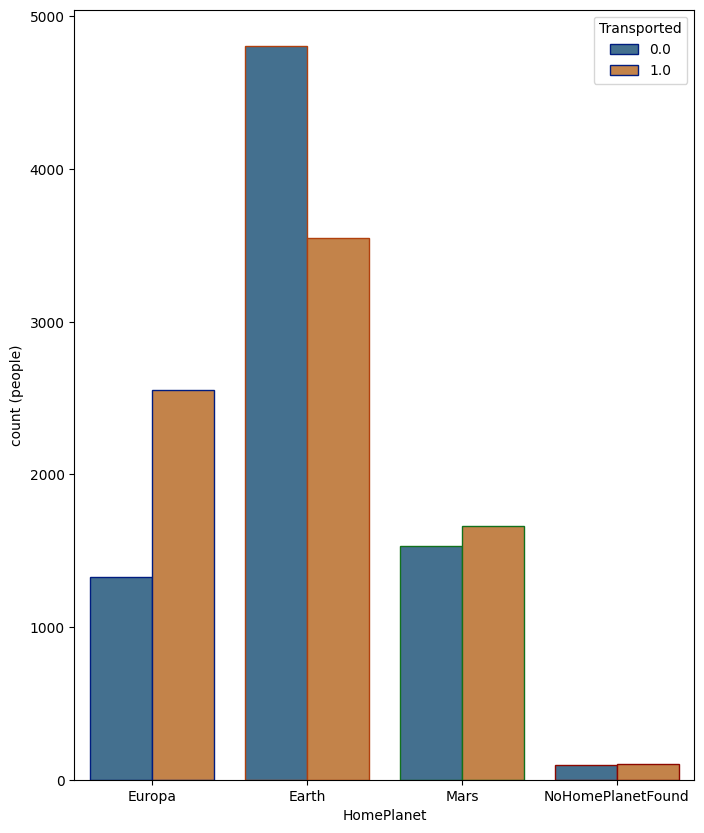

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='HomePlanet', hue='Transported', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.ylabel("count (people)")
plt.show()

#adjust legend

Europa

Roughly 35% of people from Europa did not get transported to another dimension.

Roughly 65% of people from Europa did get transported to another dimension.

Earth

Roughly 60% of people from Earth did not get transported to another dimension.

Roughly 40% of people from Earth did get transported to another dimension.


Mars

Roughly 45% of people from Mars did not get transported to another dimension.

Rougly 55% of people from Mars did get transported to another dimension.

##Hiram

## CryoSleep Analysis

In [ ]:
df["CryoSleep"]

0       False
1       False
2       False
3       False
4       False
        ...  
4269      NaN
4270      NaN
4271      NaN
4272      NaN
4276      NaN
Name: CryoSleep, Length: 46656, dtype: object

Hypothesis 3: 64% of people were not placed in cryosleep.

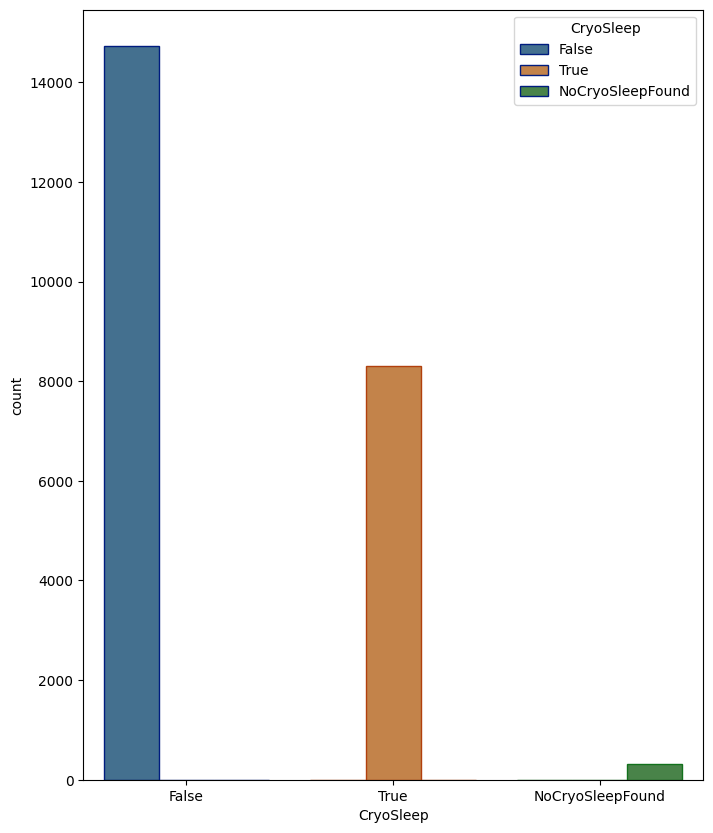

False               14721
True                 8297
NoCryoSleepFound      310
Name: CryoSleep, dtype: int64

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='CryoSleep', hue='CryoSleep', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.show()
df['CryoSleep'].value_counts()

#adjust legend

Hypothesis 4: More people from Earth decided not to be placed in cryosleep.

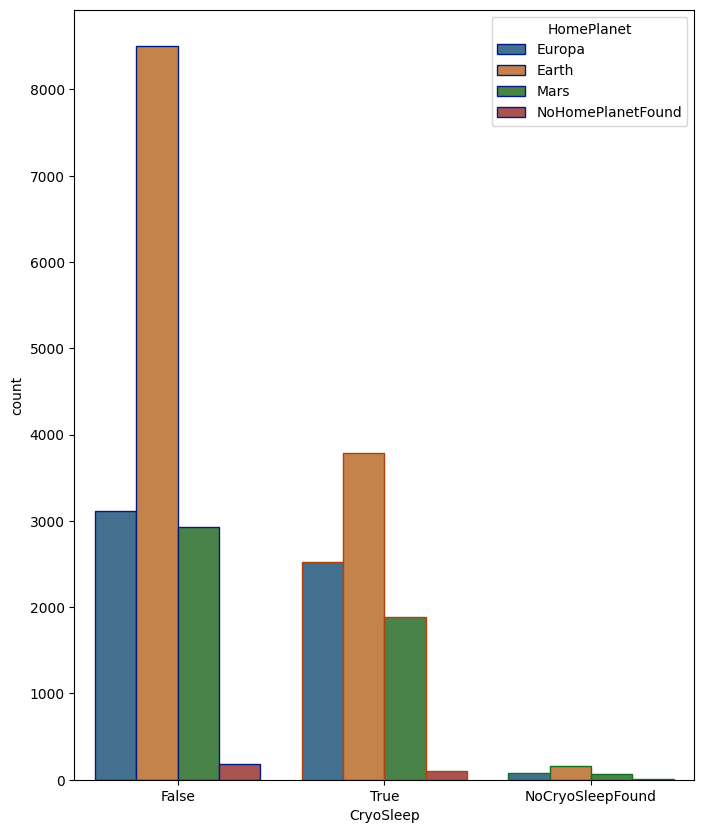

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='CryoSleep', hue='HomePlanet', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.show()

More people decided not to be placed in CryoSleep. However, the amount of people who decided not to be placed in CryoSleep is more than double for people from Earth. The other HomePlanets, Europa and Mars, are almost equal.

Hypothesis 5: For people who were not placed in cryosleep more than half were transported to another dimension.

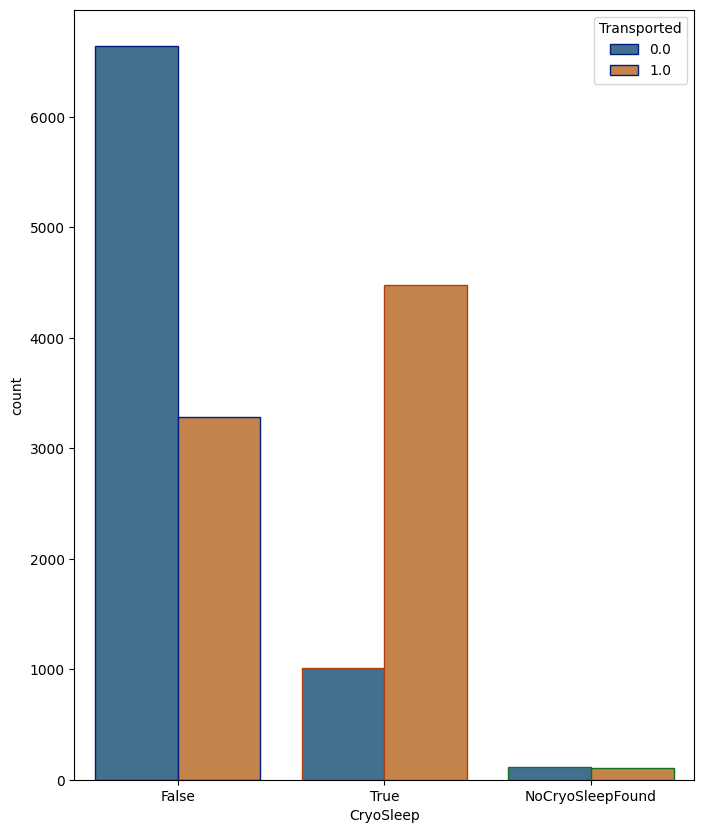

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='CryoSleep', hue='Transported', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.show()

#adjust legend

It appears that being placed in CryoSleep played a factor in whether a passenger was sent to another dimension.

For people who were not placed in CryoSleep, 50% of them were not transported to another dimension.

For people who were placed in CryoSleep, 80% of them were transported to another dimension.

##Mitchell

## Cabin Analysis

In [ ]:
df["Cabin"]

KeyError: ignored

Hypothesis 6: 32.9% of people were on Deck F on the spaceship titanic.

In [ ]:
df[["Deck", "Number", "Side"]] = df["Cabin"].str.split('/', expand = True)

plt.figure(figsize=(8,10))
df['Deck'].value_counts(normalize = True).plot.pie(title = 'Deck', autopct='%1.1f%%')

#find somethign to do with this. Gunay will go in

KeyError: ignored

In [ ]:
df["Number"]

KeyError: ignored

Hypothesis 7: more than half of the passengers were on the accident side of the ship.

In [ ]:
df[["Deck", "Number", "Side"]] = df["Cabin"].str.split('/', expand = True)

plt.figure(figsize=(8,10))
df['Side'].value_counts(normalize = True).plot.pie(title = 'Side', autopct='%1.1f%%')

KeyError: ignored

Hypothesis 8: Passengers that were on Deck F were more likely to not be transported by the anomaly. 

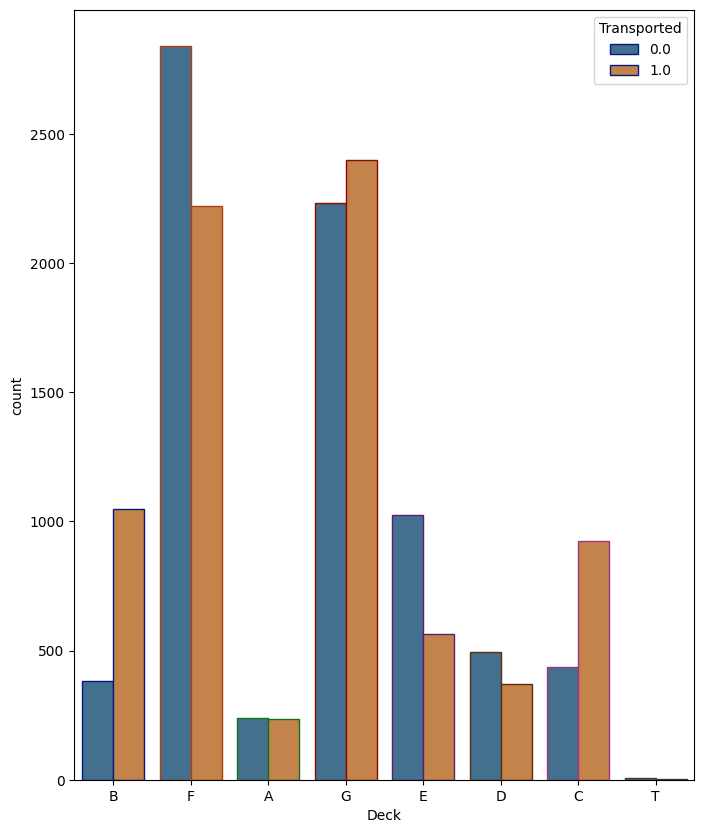

F    7707
G    6838
E    2398
B    2095
C    2008
D    1311
A     652
T      20
Name: Deck, dtype: int64

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='Deck', hue='Transported', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.show()
df['Deck'].value_counts()

Hypothesis 9: 56% of passengers that were on the side of the ship were transported to another dimension.

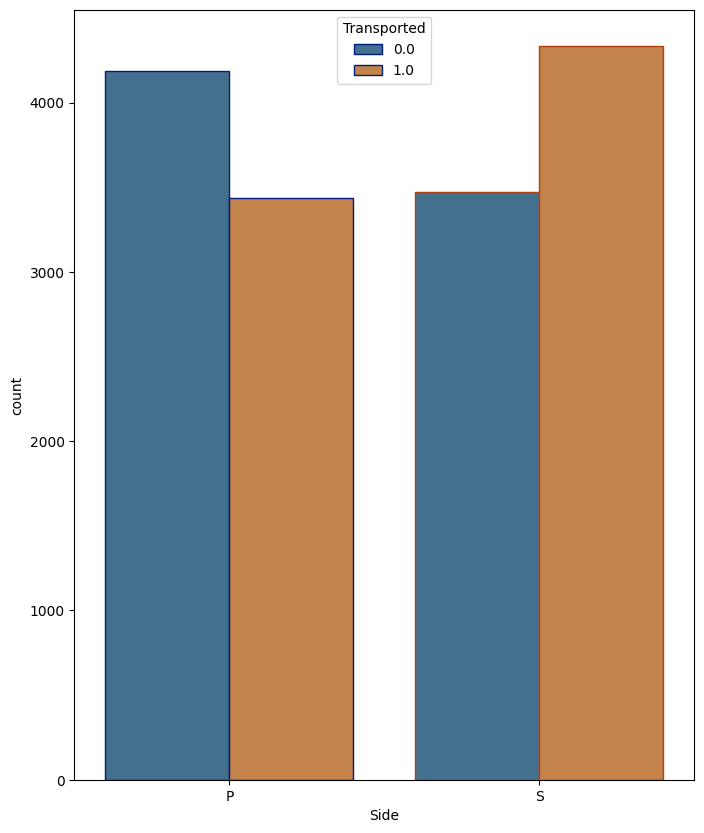

S    11601
P    11428
Name: Side, dtype: int64

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='Side', hue='Transported', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.show()
df['Side'].value_counts()

63% of people were placed in either Deck G or F. The other 37% were spread across the other 6 Decks.


The amount of people that were on the port and starboard is basically even.

For Deck B, G, and C most of the passengers were transported to another dimension.

For Deck F, A, E, D, and T most of the passengers were not transported to another dimension.

Most of the people who were on the port were not transported to another dimension.

Most of the people who were on the starboard were transported to another dimension.

##Mitchell

## Destination Analysis

Hypothesis 10: 70 percent of the passengers had their destination set on Trappist-le.

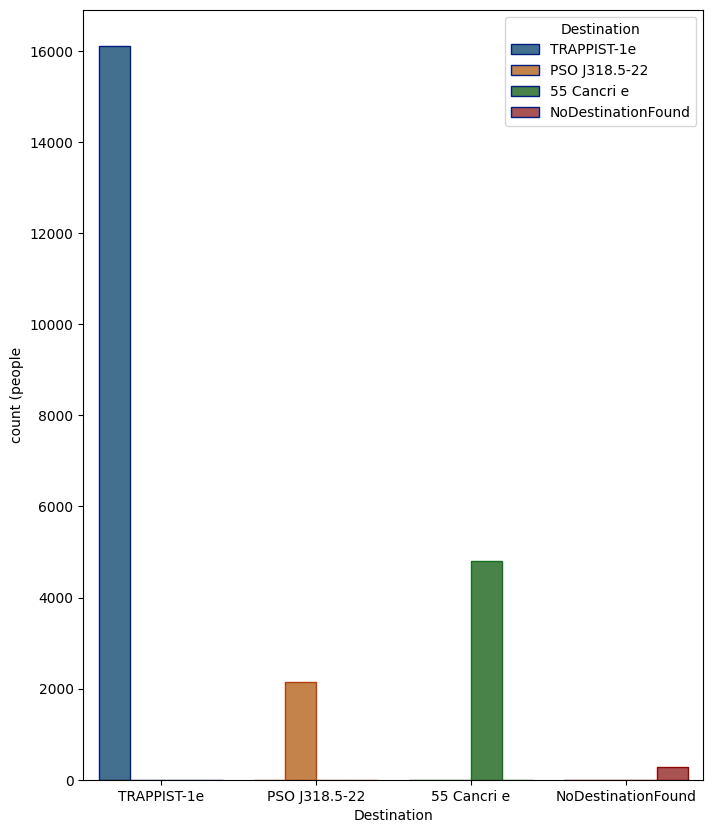

TRAPPIST-1e           16100
55 Cancri e            4798
PSO J318.5-22          2156
NoDestinationFound      274
Name: Destination, dtype: int64

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='Destination', hue='Destination', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.ylabel("count (people")
plt.show()
df['Destination'].value_counts()

Hypothesis 11: 56% of people who had their destination as Trappist-1e were not transported to another dimension.

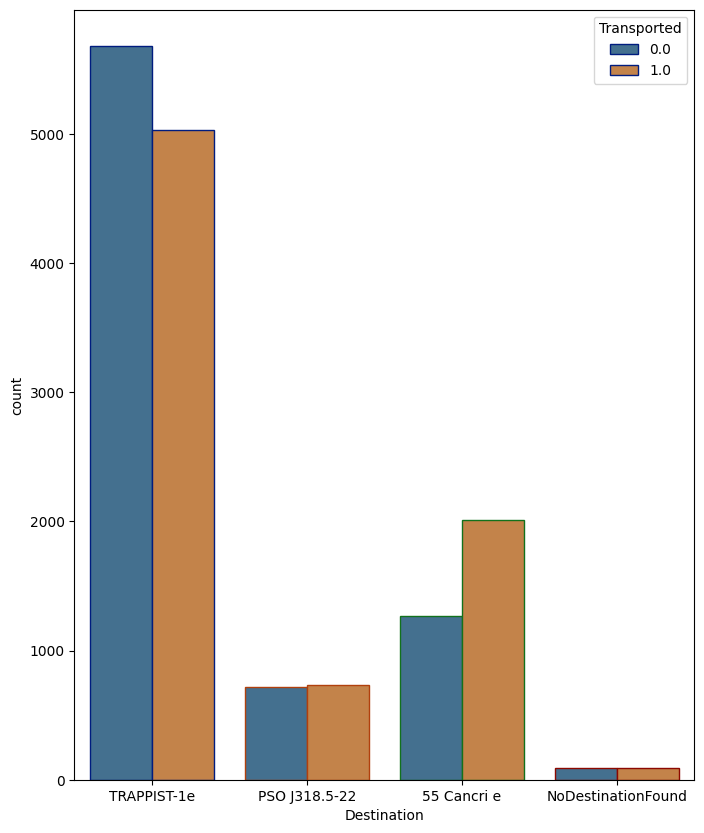

TRAPPIST-1e           16100
55 Cancri e            4798
PSO J318.5-22          2156
NoDestinationFound      274
Name: Destination, dtype: int64

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='Destination', hue='Transported', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.show()
df['Destination'].value_counts()

#edit legend and axis to be more readable

People who had their destination set as Trappist-1e were less likely to be transported to another dimension.

People who had their destination set as PSO or Cancri were more likely to be transported by the anomaly. 

##Bradley

## Age Analysis 

Hypothesis 12: 19 year olds were more likely to not be transported to another dimension.

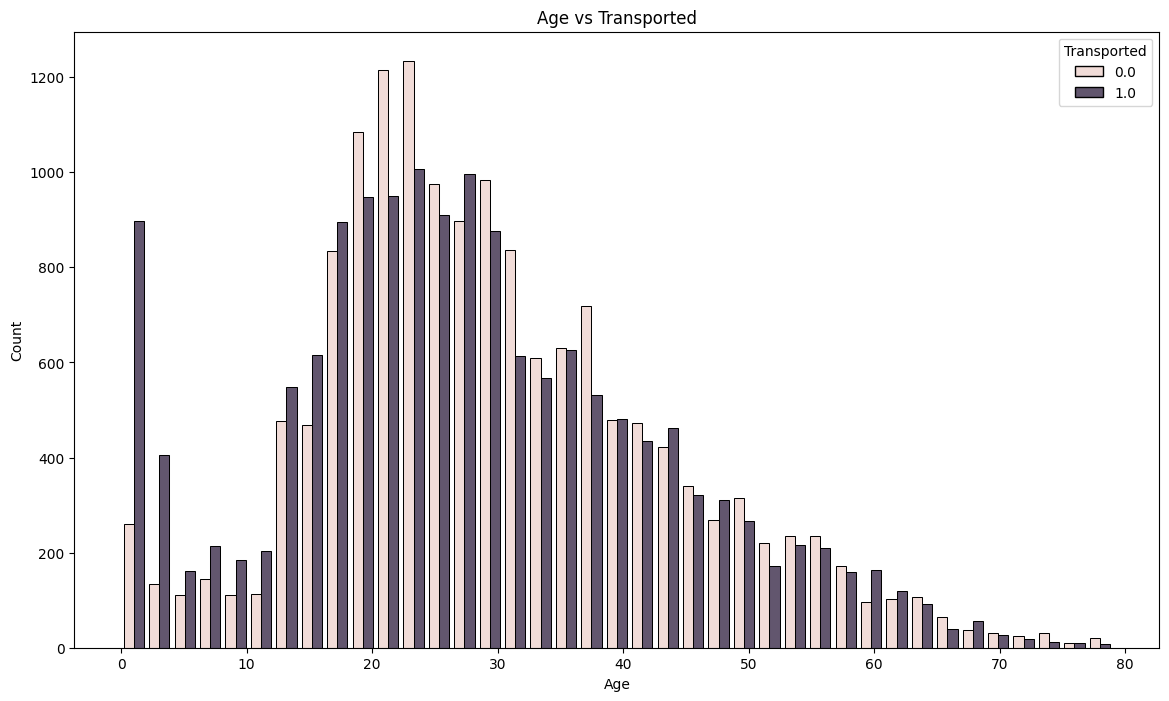

In [ ]:
plt.figure(figsize=(14,8))
sns.histplot(x= df["Age"],hue="Transported", multiple = "dodge", data = df, shrink=.8, bins = 39)
plt.title("Age vs Transported")
plt.show()


#reconfigure to have <18 and >18
#create four lists that parse DF and filters by age
  #live and die for both groups 


For Age, those who are less than 15 years old have a higher chance of being transported to another dimension.

##Hiram

##VIP Analysis

Hypothesis 13a: 97.7 percent of people did not pay for the VIP service on this voyage.

0    45662
1      994
Name: VIP, dtype: int64

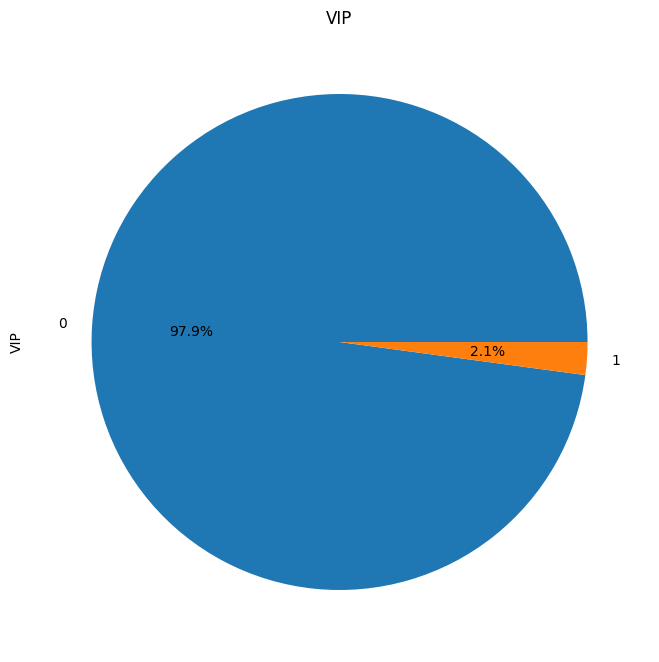

In [ ]:
plt.figure(figsize=(8,10))
df['VIP'].value_counts(normalize = True).plot.pie(title = 'VIP', autopct='%1.1f%%')
df['VIP'].value_counts()

#ylabel needs to change.

Hypothesis 13b: Did VIP status influence survival rate?

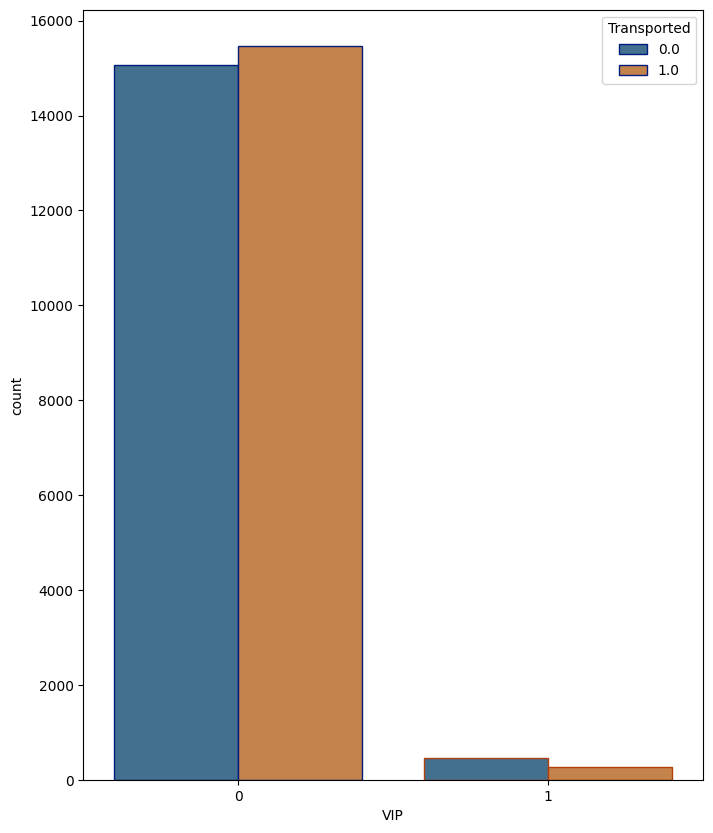

0    45662
1      994
Name: VIP, dtype: int64

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='VIP', hue='Transported', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.show()
df['VIP'].value_counts()

#adjust legend

If you did not pay for VIP services, then you were less likely to survive.

If you paid for VIP services then you were more likely to survive.

Only 199 people decided to pay, given that most people decided to not pay for VIP by a vast margin, we don't believe it played a significant role in whether passengers were sent to another dimension. 

##Bradley

## RoomService FoodCourt	ShoppingMall	Spa	VRDeck Analysis

Hypothesis 14: People who decided to spend at least $2500 at the FoodCourt and ShoppingMall were more likely to be transported to another dimension.

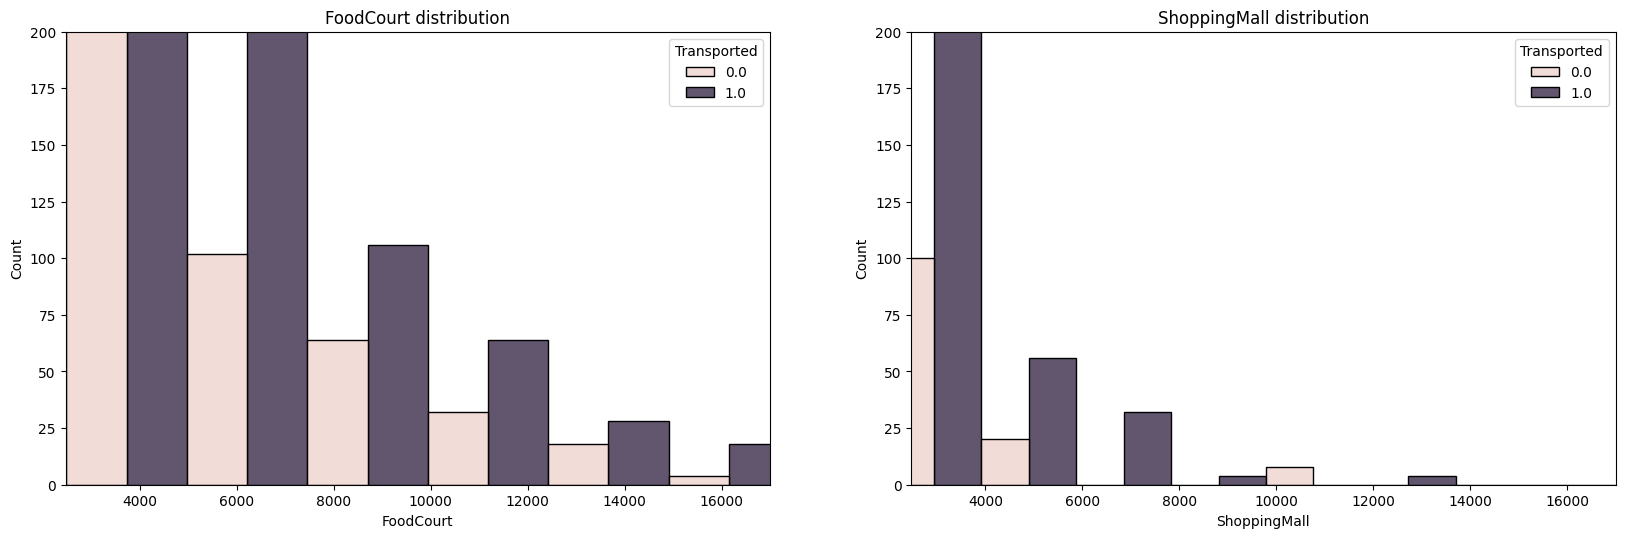

In [ ]:
plt.figure(figsize=(20,20))
plt.title("Spaceship Titanic's luxury amenities")

amenities1 = ['FoodCourt', 'ShoppingMall']
addingint = 0

for i in amenities1:
    addingint = addingint+1
    plt.subplot(3, 2, addingint)
    sns.histplot(data = df, x = df[i], hue = 'Transported', multiple = "dodge", bins = 12)
    plt.title(i + ' distribution')
    plt.xlim(2469,17000)
    plt.ylim(0,200) 

    #adjust legend. consider ways to make this more readable

Hypothesis 15: People who decided to spend at least $2500 at the RoomService, VRDeck, & Spa were less likely to be transported to another dimension.

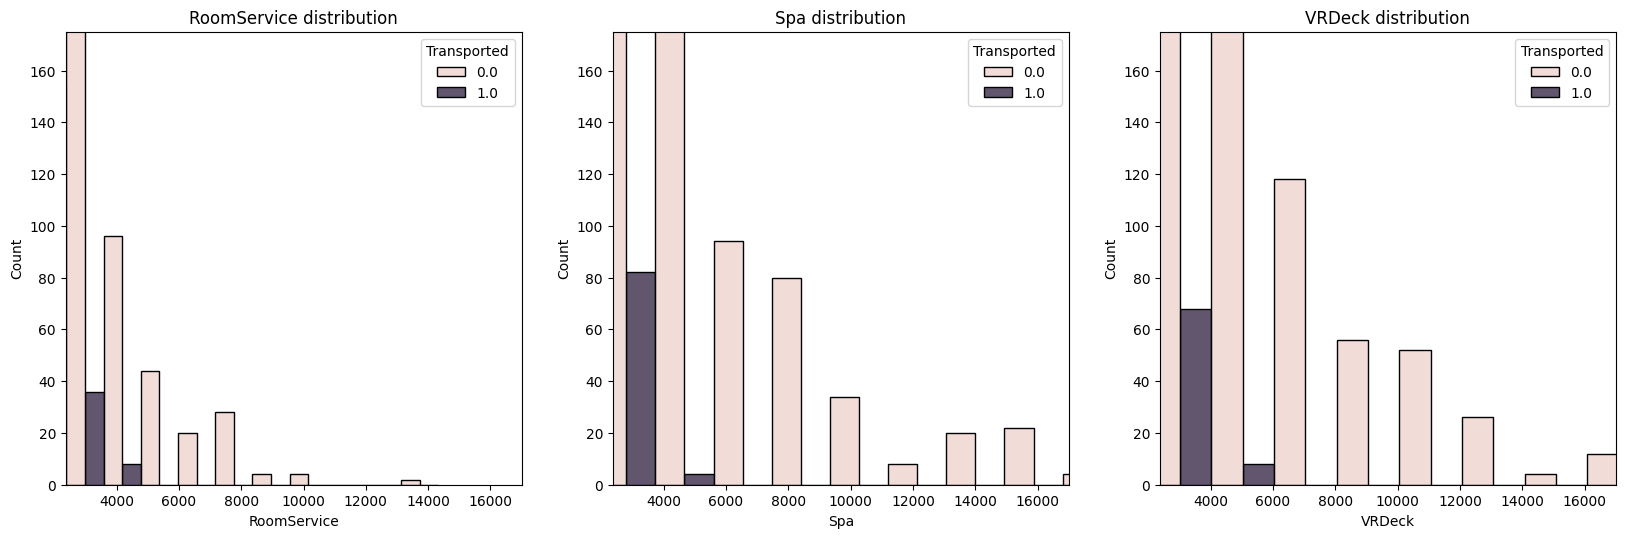

In [ ]:
plt.figure(figsize=(20,20))
plt.title("Spaceship Titanic's luxury amenities")

amenities2 = ['RoomService', 'Spa', 'VRDeck']
addingint = 0

for i in amenities2:
    addingint = addingint+1
    plt.subplot(3, 3, addingint)
    sns.histplot(data = df, x = df[i], hue = 'Transported', multiple = "dodge", bins = 12)
    plt.title(i + ' distribution')
    plt.xlim(2370,17000)
    plt.ylim(0,175) 

    #adjust legends

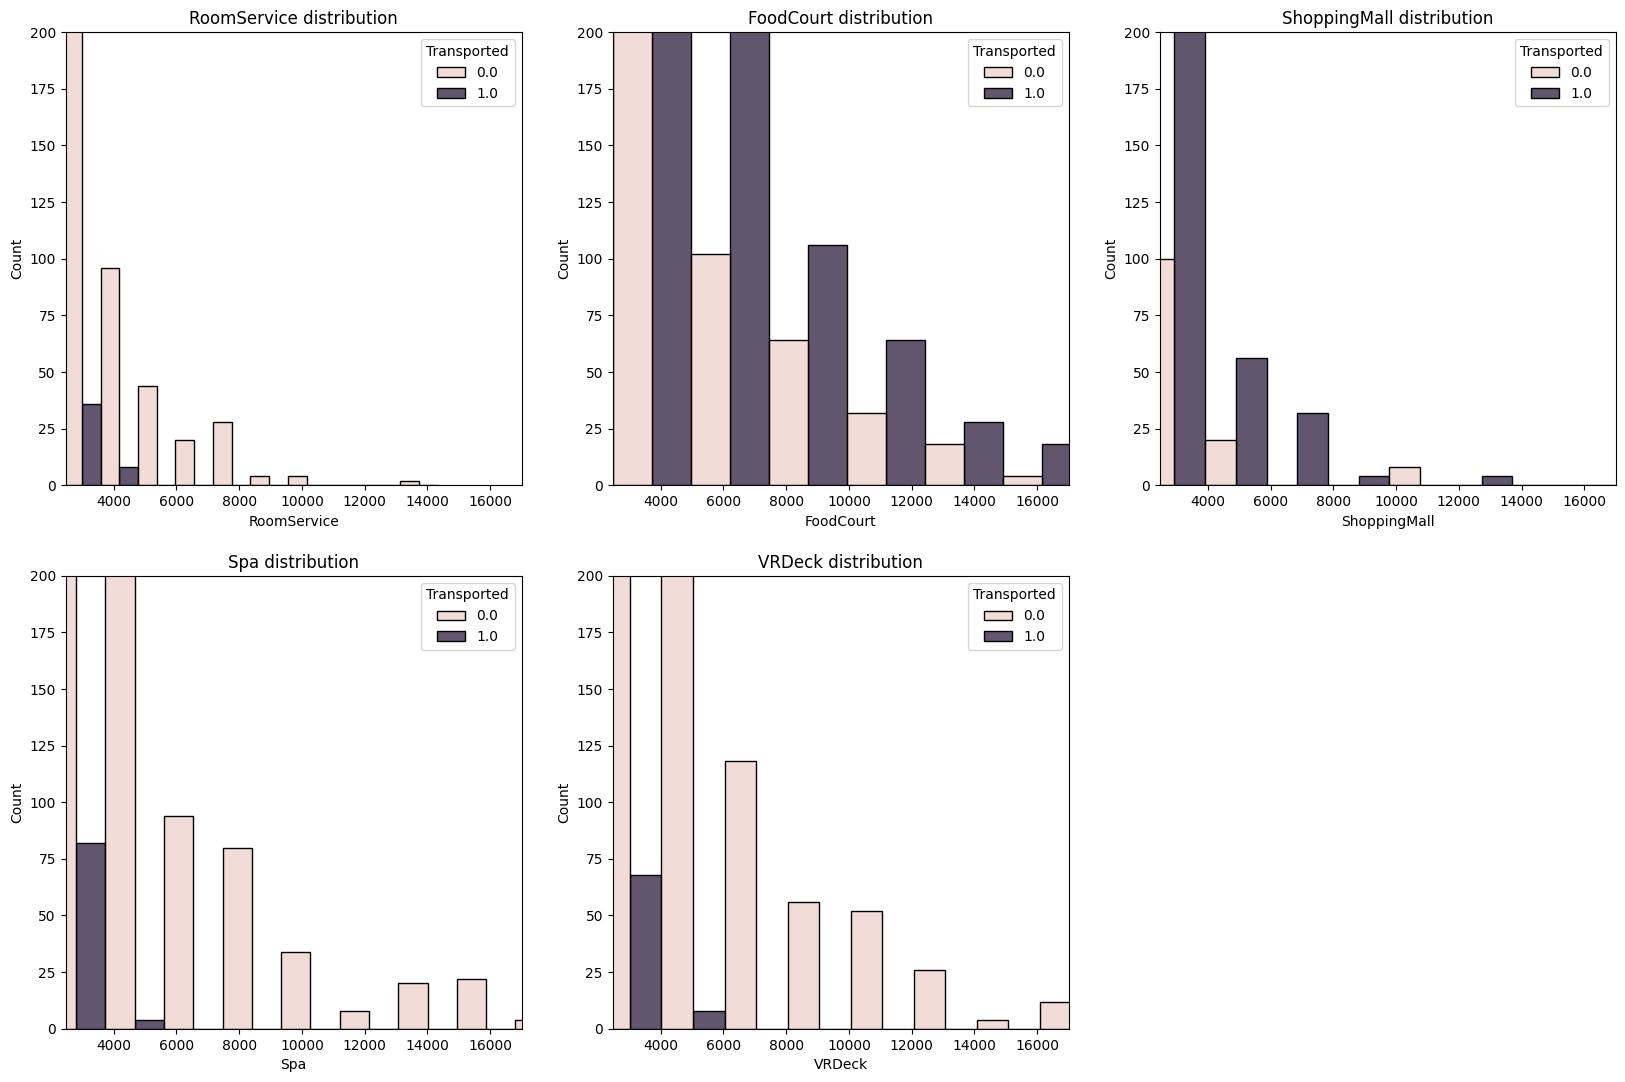

In [ ]:
plt.figure(figsize=(20,20))
plt.title("Spaceship Titanic's luxury amenities")

amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
addingint = 0

for i in amenities:
    addingint = addingint+1
    plt.subplot(3, 3, addingint)
    sns.histplot(data = df, x = df[i], hue = 'Transported', multiple = "dodge", bins = 12)
    plt.title(i + ' distribution')
    plt.xlim(2469,17000)
    plt.ylim(0,200) 


    #adjust legend

For amenities spending, if you are spending more than $2000 on RoomService, Spa, or VRDeck, then you are less likely to be sent to another dimension. 

If you are spending more than $2000 on FoodCourt, or ShoppingMall, then you are more likely to be sent to another dimension.

Hypothesis 16: Those who didn't spend anything at any of the amenities (spending = $0), have a higher chance to be transported by the anomaly.

##Hiram

## Transported Analysis

Hypothesis 17: .503% of the passengers were transported by the anomaly.

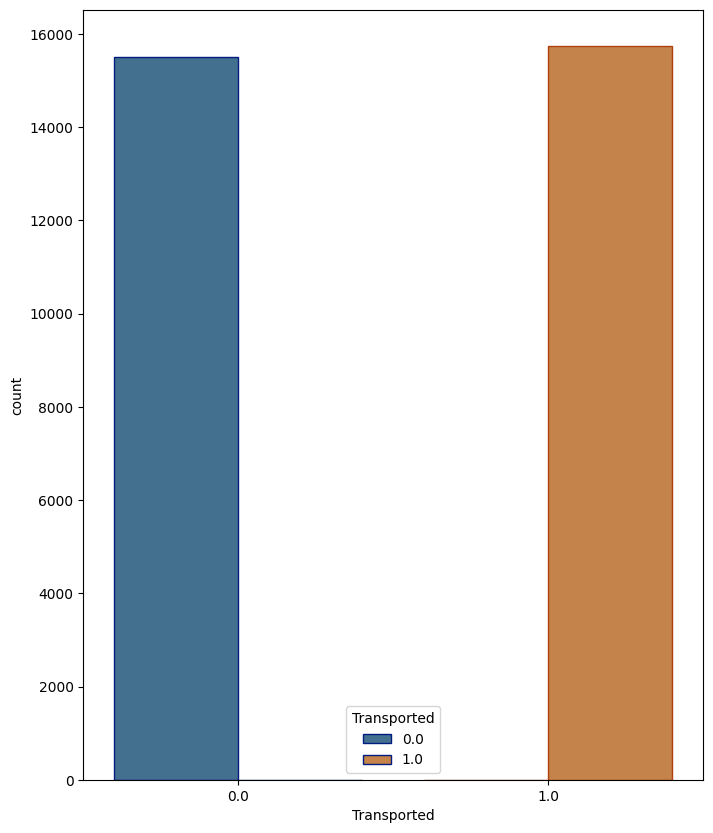

1.0    15734
0.0    15512
Name: Transported, dtype: int64

In [ ]:
fig=plt.figure(figsize=(8,10))
sns.countplot(data=df, x='Transported', hue='Transported', saturation=0.5, edgecolor=sns.color_palette("dark"))
plt.show()
df['Transported'].value_counts()

#adjust legend

In [ ]:
X = np.array(train_df_nulldropped_ohe.drop(columns=['Transported']))
y = np.array(train_df_nulldropped_ohe[['Transported']])

X_train = X
y_train = y

In [ ]:
# def estimate_coef(x, y):
#     # number of observations/points
#     n = np.size(x)
  
#     # mean of x and y vector
#     m_x = np.mean(x)
#     m_y = np.mean(y)
  
#     # calculating cross-deviation and deviation about x
#     SS_xy = np.sum(y*x) - n*m_y*m_x
#     SS_xx = np.sum(x*x) - n*m_x*m_x
  
#     # calculating regression coefficients
#     b_1 = SS_xy / SS_xx
#     b_0 = m_y - b_1*m_x
  
#     return (b_0, b_1)
  
# def plot_regression_line(x, y, b):
#     # plotting the actual points as scatter plot
#     plt.scatter(x, y, color = "m",
#                marker = "o", s = 30)
  
#     # predicted response vector
#     y_pred = b[0] + b[1]*x
  
#     # plotting the regression line
#     plt.plot(x, y_pred, color = "g")
  
#     # putting labels
#     plt.xlabel('x')
#     plt.ylabel('y')
  
#     # function to show plot
#     plt.show()

# b = estimate_coef(X_train, y_train)
# print("Estimated coefficients:\nb_0 = {}  \ \nb_1 = {}".format(b[0], b[1]))
  
# #plotting regression line
# plot_regression_line(X_train, y_train, b)



reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(test_df_nulldropped_ohe)
y_pred

array([[0.70486203],
       [0.14497796],
       [1.06946058],
       ...,
       [0.432498  ],
       [0.74207655],
       [0.72376974]])

In [ ]:
# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error

Coefficients: 
 [[-2.34390805e-03 -5.56758010e-02 -1.21188342e-04  4.29614601e-05
   7.80169776e-05 -8.75806534e-05 -8.41236060e-05  1.84665996e-06
   6.61495471e-03  2.00400402e-05 -1.10861779e-01  1.17726682e-01
  -6.86490352e-03 -1.86883735e-01  1.86883735e-01  3.94876081e-02
  -1.50723443e-02 -2.44152638e-02 -8.90598632e-02  2.35264327e-02
   4.77504221e-02 -3.04921650e-02 -8.26300329e-02  8.17492425e-03
  -3.37814686e-02  1.56511751e-01 -4.61978133e-02  4.61978133e-02]]


ValueError: ignored

In [ ]:
kernal 
svm 
not linear svm
ANN  - good 
light xboost
KNN 


#SVM needs a all numbers data frame. One Hot Encoding  = X = features DF
# Y = Target df


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


X_normalized = MinMaxScaler().fit_transform(X.values)
X = pd.DataFrame(X_normalized)

The amount of people that were transported by the anomaly versus the amount of people that were not, was very close. The goal of the Spaceship Titanic Challenge is to determine the contributing factors to whether someone was transported to another dimension. 10 out of the 13 factors played a part. The passenger ID, whether they paid for VIP, and the names of the passengers did not play a part in this crisis. We hope that this analysis will be sufficient enough for the next set of passengers that take a voyage on the Spaceship Titanic.